# Naive word2vec

This task can be formulated very simply. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

You can use TensorFlow/PyTorch (numpy too, if you love to calculate gradients on your own and want some extra points, but don't forget to numerically check your gradients) and code from your previous task. Again: you don't have to implement negative sampling (you may reduce your vocabulary size for faster computation).

**Results of this task**:
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)
 * qualitative evaluations of word vectors: nearest neighbors, word analogies

**Extra:**
 * quantitative evaluation:
   * for intrinsic evaluation you can find datasets [here](https://aclweb.org/aclwiki/Analogy_(State_of_the_art))
   * for extrincis evaluation you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

Also, you can find any other datasets for quantitative evaluation. If you chose to do this, please use the same datasets across tasks 3, 4, 5 and 6.

Again. It is **highly recommended** to read this [paper](https://arxiv.org/pdf/1411.2738.pdf)

Example of visualization in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec](https://www.tensorflow.org/images/tsne.png)

If you struggle with something, ask your neighbor. If it is not obvious for you, probably someone else is looking for the answer too. And in contrast, if you see that you can help someone - do it! Good luck!

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

### Подготовка данных

Будем использовать дефолтный текст ('text8'). Повторим простую предобработку текста из задания 2: удалим из текста стопслова и слишком редкие слова (встречающиеся менее 25 раз).
Также создадим батчер для SkipGram модели. Он генерирует батчи, состоящие из n пар слов (x, y), где x - центрально еслово, y - некоторое слово из окна вокруг центрального слова.

In [2]:
from preprocessing import prepare_data
frequent_words, token2id, id2token, batcher = prepare_data(min_count=25, shuffle=False)
print(f'Vocab size: {len(token2id)}')

Vocab size: 27790


### Модель

In [3]:
class Word2VecModel():
    def __init__(self, params):
        self.embeddings = tf.get_variable(name='embedding_matrix', 
                                          shape=[params['vocab_size'], params['embedding_dim']], 
                                          dtype=tf.float32, 
                                          trainable=True)
        
        self.weights = tf.get_variable(name='weight_matrix', 
                                       shape=[params['embedding_dim'], params['vocab_size']], 
                                       trainable=True)
        
        self.inputs = tf.placeholder(shape=(None), dtype=tf.int32, name='inputs')
        self.targets = tf.placeholder(shape=(None), dtype=tf.int32, name='targets')
        self.learning_rate = tf.placeholder(shape=[], dtype=tf.float32, name='learning_rate')
        
        self.inputs_embedded = tf.nn.embedding_lookup(self.embeddings, self.inputs)
        self.logits = self.inputs_embedded @ self.weights
        self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.targets, logits=self.logits))
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.train_op = self.optimizer.minimize(self.loss, global_step=tf.train.get_global_step())
        
        self.loss_history = []
    
    def train(self, session, inputs, targets, learning_rate):
        feed_dict = {
            self.inputs: inputs, 
            self.targets: targets,
            self.learning_rate: learning_rate,
        }
    
        loss, _ = session.run([self.loss, self.train_op], feed_dict=feed_dict)
        
        return loss


In [4]:
def train_model(model, session, batcher, batch_size, num_epochs, learning_rate, loss_history, print_every=100):
    train_iter = int(np.ceil(len(batcher.data) / batch_size))
    print('Start training... \n')
    
    for epoch in range(1, num_epochs + 1):
        batcher.shuffle()
        
        print(f'Epoch {epoch}/{num_epochs}:')        
        epoch_loss = 0
        intermediate_loss = 0
        
        for i, (inputs, targets) in enumerate(batcher.generate_batches(batch_size=batch_size), 1):
            current_loss = model.train(session=session, 
                                       inputs=inputs, 
                                       targets=targets, 
                                       learning_rate=learning_rate)
            
            epoch_loss += current_loss
            intermediate_loss += current_loss
            loss_history.append(current_loss)
            
            if i % print_every == 0 or (i == 1 and epoch == 1) or i == train_iter:
                if i == 1:
                    div = 1
                elif i == train_iter:
                    div = train_iter % print_every
                else:
                    div = print_every
                print(f'Epoch: [{epoch}/{num_epochs}], step: [{i}/{train_iter}], mean loss: {intermediate_loss / div}')
                if i != 1:
                    intermediate_loss = 0
        
        print(f'Epoch {epoch} finished, mean loss during epoch {epoch}: {epoch_loss / train_iter} \n')
    
    print('...training finished.')

In [5]:
def plot_loss(losses, average_over_batches=1, upper_bound=None):
    average_losses = [np.mean(losses[i:i+average_over_batches+1]) for i in range(0, len(losses), average_over_batches)]
    indices = list(range(average_over_batches, len(losses), average_over_batches)) + [len(losses)]
    plt.plot(indices, average_losses, '-')
    plt.grid(True)
    plt.title('Training loss')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    if upper_bound is not None:
        plt.ylim(top=upper_bound)
    plt.show()

### Обучение

Обучим word2vewc модель с эмбеддингами размерности 50.

In [6]:
params = {
    'embedding_dim': 50, 
    'vocab_size': len(token2id)
}

In [7]:
tf.reset_default_graph()
np.random.seed(111)
tf.set_random_seed(111)

In [8]:
model = Word2VecModel(params)

In [9]:
%%time

session = tf.Session()
session.run(tf.global_variables_initializer())

train_model(model=model, 
            session=session, 
            batcher=batcher, 
            num_epochs=3, 
            batch_size=2048, 
            learning_rate=1e-3, 
            loss_history=model.loss_history, 
            print_every=3000)

Start training... 

Epoch 1/3:
Epoch: [1/3], step: [1/29334], mean loss: 10.232416152954102
Epoch: [1/3], step: [3000/29334], mean loss: 8.295458582401276
Epoch: [1/3], step: [6000/29334], mean loss: 8.036851735432943
Epoch: [1/3], step: [9000/29334], mean loss: 7.938734637737274
Epoch: [1/3], step: [12000/29334], mean loss: 7.855325692335764
Epoch: [1/3], step: [15000/29334], mean loss: 7.797161047140757
Epoch: [1/3], step: [18000/29334], mean loss: 7.757543628851573
Epoch: [1/3], step: [21000/29334], mean loss: 7.726457229137421
Epoch: [1/3], step: [24000/29334], mean loss: 7.703418858528138
Epoch: [1/3], step: [27000/29334], mean loss: 7.684057866414388
Epoch: [1/3], step: [29334/29334], mean loss: 7.6725914972709
Epoch 1 finished, mean loss during epoch 1: 7.850714406101073 

Epoch 2/3:
Epoch: [2/3], step: [3000/29334], mean loss: 7.644977852026622
Epoch: [2/3], step: [6000/29334], mean loss: 7.640191334247589
Epoch: [2/3], step: [9000/29334], mean loss: 7.63565370241801
Epoch: [2/

Обучение в течение трех эпох заняло чуть больше часа на GTX 1050 Ti.

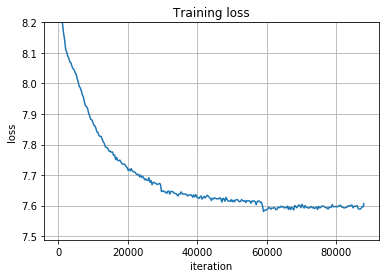

In [15]:
plot_loss(model.loss_history, average_over_batches=300, upper_bound=8.2)

In [17]:
embeddings = session.run(model.embeddings)
session.close()

### Оценка качества эмбеддингов

In [18]:
def get_embedding(token):
    '''Returns embedding for given token.'''
    
    return embeddings[token2id[token]]

def most_similar_to_embedding(input_embedding, embeddings, num_neighbors=10):
    '''Returns embeddings closest to given embedding measured by cosine similarity.'''
    
    distances = cosine_similarity(embeddings, input_embedding.reshape(1, -1)).reshape(-1)
    neighbor_indices = np.argpartition(distances, -num_neighbors-1)[-num_neighbors-1:]
    sorted_neighbor_indices = list(reversed(neighbor_indices[np.argsort(distances[neighbor_indices])]))
    return [id2token[idx] for idx in sorted_neighbor_indices[1:]]

def most_similar_to_token(token, embeddings, num_neighbors=10):
    '''Returns embeddings closest to embedding of given token measured by cosine similarity.'''
    
    return  most_similar_to_embedding(get_embedding(token), embeddings, num_neighbors)


Найдем самые близкие по косинусному расстоянию между эмбеддингами слова для слов fly, car, earth, computer, machine.

In [19]:
most_similar_to_token('fly', embeddings)

['airplane',
 'pilots',
 'flight',
 'misses',
 'gliders',
 'flying',
 'safely',
 'flew',
 'pilot',
 'flies']

In [20]:
most_similar_to_token('car', embeddings)

['driver',
 'racer',
 'cars',
 'racing',
 'motorcycle',
 'automobile',
 'nascar',
 'truck',
 'raced',
 'porsche']

In [21]:
most_similar_to_token('earth', embeddings)

['planet',
 'moon',
 'orbit',
 'planets',
 'jupiter',
 'magnetosphere',
 'jovian',
 'surface',
 'sun',
 'habitable']

In [22]:
most_similar_to_token('computer', embeddings)

['computers',
 'computing',
 'hardware',
 'microcomputer',
 'supercomputer',
 'scanners',
 'peripherals',
 'laptop',
 'simulation',
 'computerized']

In [23]:
most_similar_to_token('machine', embeddings)

['machines',
 'automatic',
 'bootstrap',
 'optimized',
 'microprogram',
 'submachine',
 'bytecode',
 'enigma',
 'cisc',
 'assemblers']

Почти все полученные ближайшие соседи являются адекватными по смыслу.

Теперь попробуем получить корректные аналогии.

In [24]:
input_embedding = get_embedding('king') - get_embedding('man') + get_embedding('woman')
most_similar_to_embedding(input_embedding, embeddings)

['daughter',
 'son',
 'childless',
 'matilda',
 'wife',
 'wed',
 'brother',
 'reigned',
 'marries',
 'marrying']

Классический пример с king - man + woman не сработал. Ничего похожего на queen среди ближайших соседей нет.

Однако, неокторые другие аналогии работают:

In [25]:
input_embedding = get_embedding('airplane') - get_embedding('pilot') + get_embedding('driver')
most_similar_to_embedding(input_embedding, embeddings)

['car',
 'nascar',
 'race',
 'automobile',
 'racing',
 'bike',
 'racer',
 'cars',
 'racers',
 'motorcycle']

airplane - pilot + driver = car

In [26]:
input_embedding = get_embedding('airplane') - get_embedding('pilot') + get_embedding('captain')
most_similar_to_embedding(input_embedding, embeddings)

['yacht',
 'kidd',
 'charley',
 'earle',
 'patsy',
 'holden',
 'steamer',
 'toured',
 'scouts',
 'pontiac']

airplane - pilot + captain = yacht

In [27]:
input_embedding = get_embedding('ball') - get_embedding('football') + get_embedding('hockey')
most_similar_to_embedding(input_embedding, embeddings)

['puck',
 'cue',
 'skates',
 'tee',
 'stick',
 'balls',
 'drilled',
 'hitting',
 'outfield',
 'thrower']

ball - football + hockey = puck

In [28]:
input_embedding = get_embedding('football') - get_embedding('europe') + get_embedding('america')
most_similar_to_embedding(input_embedding, embeddings)

['basketball',
 'soccer',
 'team',
 'baseball',
 'golfer',
 'hockey',
 'rugby',
 'club',
 'softball',
 'footy']

И даже для football - europe + america вторым результатом получаем soccer.

Теперь выберем побольше слов и визуализируем их векторные представления с помощью t-SNE.

In [30]:
test_words = ['one', 'two', 'three', 'four', 'five', 
              'russia', 'germany', 'france', 'england', 'scotland', 'britain', 'china', 'japan', 'korea', 'india', 
              'moscow', 'berlin', 'paris', 'london', 'edinburgh',
              'car', 'truck', 'bus', 'train', 'airplane', 'plane', 'ship', 'yacht', 
              'human', 'man', 'woman', 'husband', 'wife', 'parents', 'son', 'daughter', 
              'good', 'great', 'fantastic', 'bad', 'awful', 
              'walk', 'run', 'swim', 'fly', 
              'game', 'sport', 'soccer', 'football', 'basketball', 'hockey', 'tennis', 
              'music', 'song', 'guitar', 'guitarist', 'drums', 'drummer', 'singer', 'vocalist', 
              'rock', 'metal', 'punk', 'rap', 'jazz', 'blues', 'pop', 
              'north', 'south', 'east', 'west']

test_word_embeddings = np.array([get_embedding(word) for word in test_words])
distance_matrix = 1 - np.round(cosine_similarity(test_word_embeddings), decimals=4)

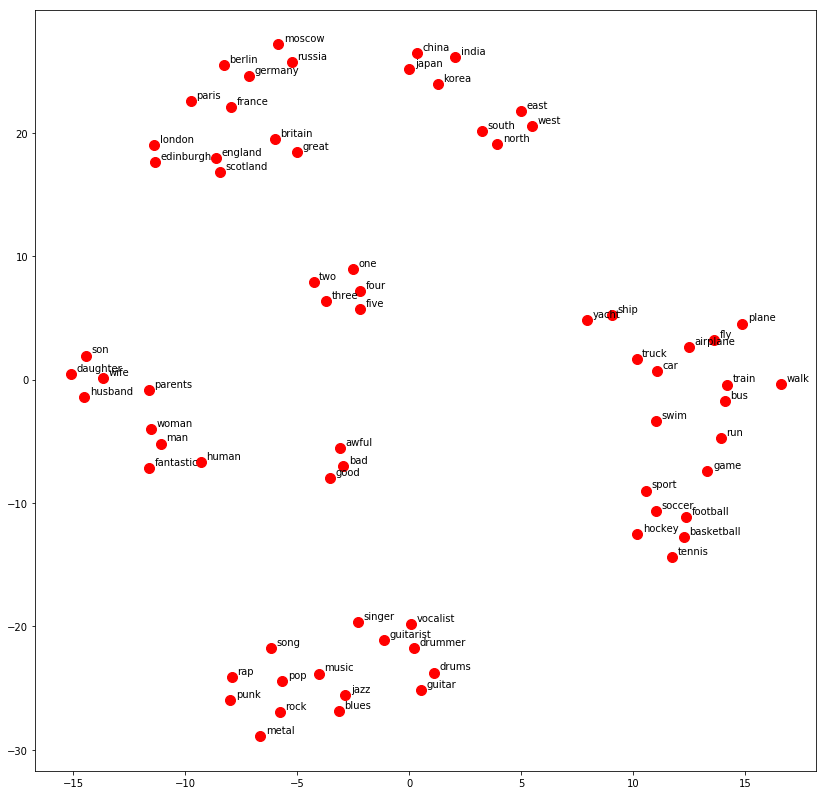

In [31]:
tsne = TSNE(perplexity=10,  # Multicore TSNE can be used
            early_exaggeration=10, 
            learning_rate=20, 
            n_iter=2000, 
            metric='precomputed', 
            method='exact', 
            random_state=15)

points = tsne.fit_transform(distance_matrix)

plt.figure(figsize=[14, 14])
plt.scatter(points[:, 0], points[:, 1], color='red', s=100)

indent = 0.25
for i in range(len(test_words)):
    coords = (points[i, 0] + indent, points[i, 1] + indent)
    plt.annotate(test_words[i], coords)

plt.show()

На визуализации слова разделились на ярко выраженные кластеры близких по смыслу слов: музыка, спорт, числа, страны и столицы...
Можно обратить внимание, что отношение страна-столица визуально получилось почти одинаковым для всех рассмотренных пар.

В целом, можно сделать вывод, что полученные векторные представления действительно содержат семантическую и синтаксическую информацию о словах.

In [33]:
with open('embeddings_task3.pickle', 'wb') as handle:
    pickle.dump(embeddings, handle)